# MeshGraphNet for Computational Fluid Dynamics

This notebook implements a Graph Neural Network (GNN) based approach for predicting fluid dynamics simulations using the MeshGraphNet architecture. The model learns to predict the evolution of velocity and pressure fields on computational fluid dynamics meshes.

## Overview

MeshGraphNet is designed to learn physics simulations on irregular meshes by:
1. Encoding mesh nodes and edges into latent representations
2. Processing these representations through message-passing layers
3. Decoding the final representations to predict future states

The notebook covers data loading, preprocessing, model implementation, training, and evaluation on CFD simulation data.

## Library Imports

Import the essential libraries needed for data processing, visualization, and file handling:
- `numpy` for numerical computations
- `matplotlib` for plotting and visualization
- `glob` for file pattern matching
- `natsort` for natural sorting of file names

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import glob
from natsort import natsorted

## Data Loading Function

Define a utility function to load CFD simulation data stored in NumPy format. The data files contain mesh information, field values (velocity and pressure), and boundary conditions for fluid dynamics simulations.

In [2]:
def load_data(data_path):
    data = np.load(data_path, allow_pickle=True).item()
    return data

## Data Exploration

Load a sample data file and examine its structure. This helps understand the format and dimensions of the CFD simulation data, including mesh coordinates, connectivity, field values, and boundary masks.

In [3]:
data_path = "data/train/data_02005.npy"

result = load_data(data_path)

for key, item in result.items():
    print(key, item.shape)

field_node (2051, 3)
coord (2051, 2)
edge_index_bi (2, 11858)
cell_node_list (3878, 3)
mask_bd (2051, 1)
mask_wall (2051, 1)
mask_inlet (2051, 1)
mask_outlet (2051, 1)
mask_object (2051, 1)
pos_diff (11858, 2)
pos_l2_norm (11858, 1)


## Understanding the Data Structure Keys

Based on the output above, here's what each key represents in the CFD simulation data:

**Mesh Geometry:**
- `coord` (2051, 2): Node coordinates in 2D space (x, y positions of mesh nodes)
- `cell_node_list` (3878, 3): Triangular cell connectivity (each row contains 3 node indices forming a triangle)

**Physical Fields:**
- `field_node` (2051, 3): Physical quantities at each node (velocity_x, velocity_y, pressure)

**Graph Structure:**
- `edge_index_bi` (2, 11858): Bidirectional edge connectivity for graph neural networks (source and target node pairs)
- `pos_diff` (11858, 2): Position differences between connected nodes (edge vectors)
- `pos_l2_norm` (11858, 1): L2 norms (lengths) of the position differences

**Boundary Conditions (Binary Masks):**
- `mask_bd` (2051, 1): General boundary nodes mask
- `mask_wall` (2051, 1): Wall boundary nodes (no-slip condition)
- `mask_inlet` (2051, 1): Inlet boundary nodes (prescribed velocity)
- `mask_outlet` (2051, 1): Outlet boundary nodes (prescribed pressure)
- `mask_object` (2051, 1): Object boundary nodes (obstacles in the flow)

The numbers show: 2051 nodes, 11858 bidirectional edges, and 3878 triangular cells in this mesh.

In [4]:
# Detailed exploration of the data values
print("=== PHYSICAL FIELDS ===")
print(f"field_node shape: {result['field_node'].shape}")
print(f"field_node range: [{result['field_node'].min():.4f}, {result['field_node'].max():.4f}]")
print(f"field_node mean per component: {np.mean(result['field_node'], axis=0)}")
print("field_node components: [velocity_x, velocity_y, pressure]")

print("\n=== MESH COORDINATES ===")
print(f"coord shape: {result['coord'].shape}")
print(f"X range: [{result['coord'][:, 0].min():.4f}, {result['coord'][:, 0].max():.4f}]")
print(f"Y range: [{result['coord'][:, 1].min():.4f}, {result['coord'][:, 1].max():.4f}]")

print("\n=== BOUNDARY MASKS (count of True values) ===")
mask_keys = ['mask_bd', 'mask_wall', 'mask_inlet', 'mask_outlet', 'mask_object']
for mask_key in mask_keys:
    count = np.sum(result[mask_key])
    percentage = count / len(result[mask_key]) * 100
    print(f"{mask_key}: {count} nodes ({percentage:.1f}%)")

print("\n=== GRAPH STRUCTURE ===")
print(f"Number of edges: {result['edge_index_bi'].shape[1]}")
print(f"Edge length range: [{result['pos_l2_norm'].min():.4f}, {result['pos_l2_norm'].max():.4f}]")
print(f"Average edge length: {np.mean(result['pos_l2_norm']):.4f}")

print("\n=== MESH TOPOLOGY ===")
print(f"Number of triangular cells: {result['cell_node_list'].shape[0]}")
print(f"Node indices range: [{result['cell_node_list'].min()}, {result['cell_node_list'].max()}]")

=== PHYSICAL FIELDS ===
field_node shape: (2051, 3)
field_node range: [-1.1015, 2.0312]
field_node mean per component: [0.94728538 0.00309647 0.11520296]
field_node components: [velocity_x, velocity_y, pressure]

=== MESH COORDINATES ===
coord shape: (2051, 2)
X range: [0.0000, 1.6000]
Y range: [0.0000, 0.4000]

=== BOUNDARY MASKS (count of True values) ===
mask_bd: 224 nodes (10.9%)
mask_wall: 130 nodes (6.3%)
mask_inlet: 17 nodes (0.8%)
mask_outlet: 17 nodes (0.8%)
mask_object: 64 nodes (3.1%)

=== GRAPH STRUCTURE ===
Number of edges: 11858
Edge length range: [0.0041, 0.0315]
Average edge length: 0.0182

=== MESH TOPOLOGY ===
Number of triangular cells: 3878
Node indices range: [0, 2050]


## Visual Data Exploration

To better understand the data structure, you can run the code cell above to see:

1. **Value ranges** for physical fields (velocity and pressure)
2. **Spatial extent** of the computational domain
3. **Boundary distribution** showing how many nodes belong to each boundary type
4. **Graph connectivity** statistics like edge count and average edge length
5. **Mesh quality** information about the triangular discretization

You can also create simple visualizations by running cells like:

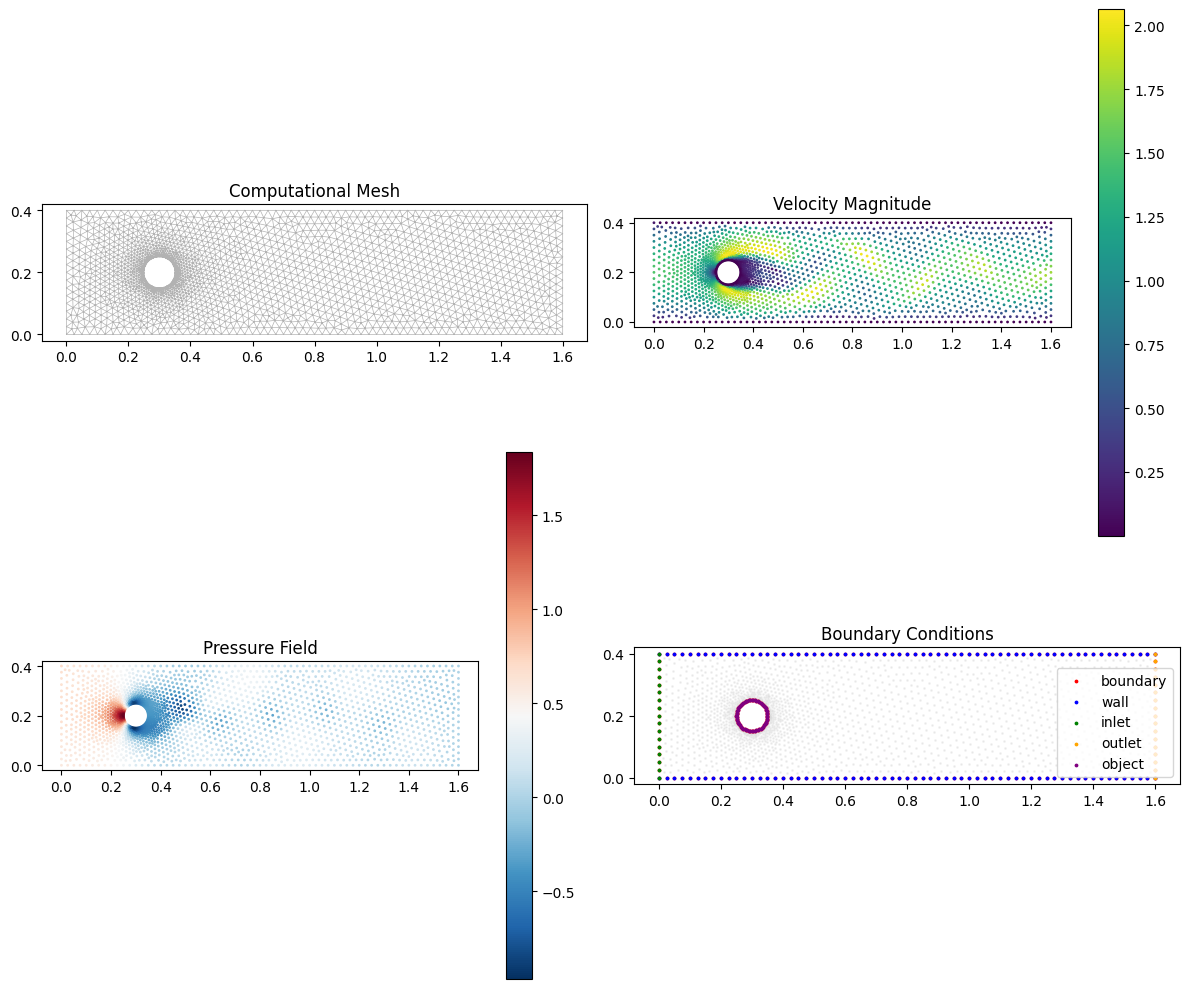

In [12]:
# Simple visualization of the mesh and boundary conditions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Mesh structure
axes[0, 0].triplot(result['coord'][:, 0], result['coord'][:, 1], result['cell_node_list'], 
                   'k-', alpha=0.3, linewidth=0.5)
axes[0, 0].set_title('Computational Mesh')
axes[0, 0].set_aspect('equal')

# Plot 2: Velocity magnitude
velocity_mag = np.sqrt(result['field_node'][:, 0]**2 + result['field_node'][:, 1]**2)
scatter1 = axes[0, 1].scatter(result['coord'][:, 0], result['coord'][:, 1], 
                              c=velocity_mag, cmap='viridis', s=1)
axes[0, 1].set_title('Velocity Magnitude')
axes[0, 1].set_aspect('equal')
plt.colorbar(scatter1, ax=axes[0, 1])

# Plot 3: Pressure field
scatter2 = axes[1, 0].scatter(result['coord'][:, 0], result['coord'][:, 1], 
                              c=result['field_node'][:, 2], cmap='RdBu_r', s=1)
axes[1, 0].set_title('Pressure Field')
axes[1, 0].set_aspect('equal')
plt.colorbar(scatter2, ax=axes[1, 0])

# Plot 4: Boundary conditions
colors = ['red', 'blue', 'green', 'orange', 'purple']
labels = ['boundary', 'wall', 'inlet', 'outlet', 'object']
axes[1, 1].scatter(result['coord'][:, 0], result['coord'][:, 1], c='lightgray', s=1, alpha=0.3)
for i, (mask_key, color, label) in enumerate(zip(mask_keys, colors, labels)):
    mask = result[mask_key].flatten().astype(bool)
    if np.any(mask):
        axes[1, 1].scatter(result['coord'][mask, 0], result['coord'][mask, 1], 
                          c=color, s=3, label=label)
axes[1, 1].set_title('Boundary Conditions')
axes[1, 1].set_aspect('equal')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

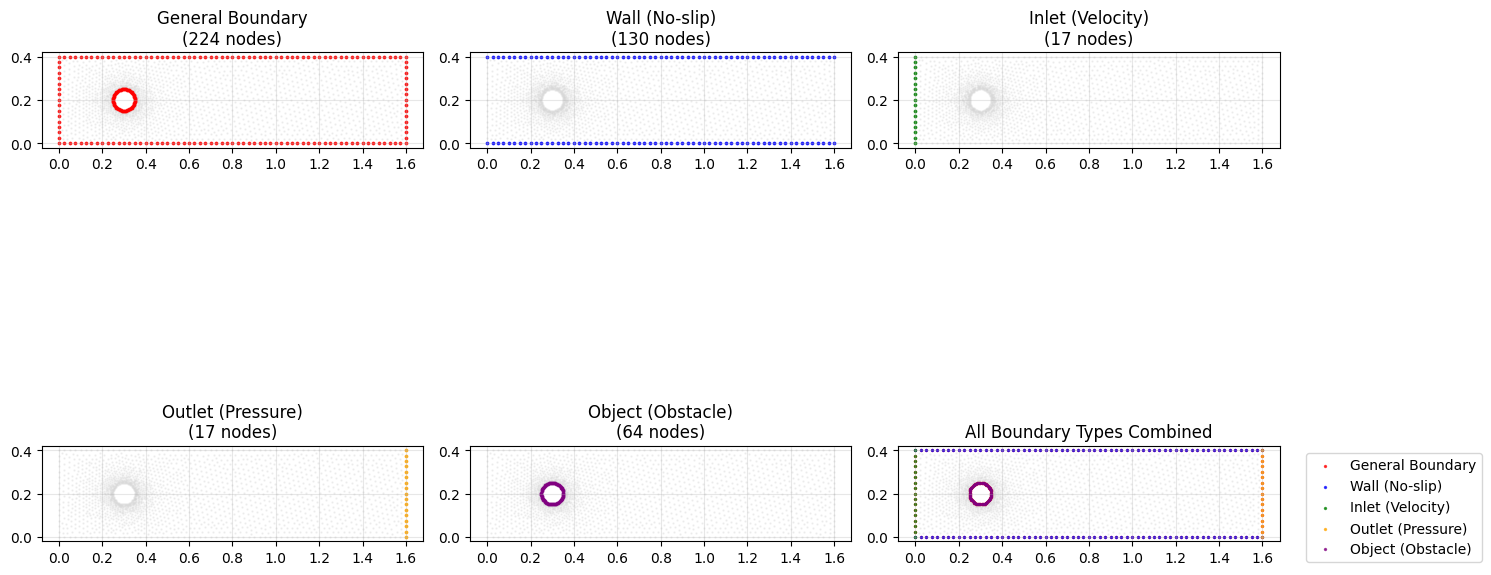

In [6]:
# Detailed visualization of individual masks
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

mask_keys = ['mask_bd', 'mask_wall', 'mask_inlet', 'mask_outlet', 'mask_object']
mask_colors = ['red', 'blue', 'green', 'orange', 'purple']
mask_labels = ['General Boundary', 'Wall (No-slip)', 'Inlet (Velocity)', 'Outlet (Pressure)', 'Object (Obstacle)']

# Plot each mask individually
for i, (mask_key, color, label) in enumerate(zip(mask_keys, mask_colors, mask_labels)):
    ax = axes[i]
    
    # Show all nodes in light gray
    ax.scatter(result['coord'][:, 0], result['coord'][:, 1], c='lightgray', s=0.5, alpha=0.3)
    
    # Highlight the specific boundary nodes
    mask = result[mask_key].flatten().astype(bool)
    count = np.sum(mask)
    
    if count > 0:
        ax.scatter(result['coord'][mask, 0], result['coord'][mask, 1], 
                  c=color, s=3, alpha=0.8)
    
    ax.set_title(f'{label}\n({count} nodes)')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

# Last subplot: Show all masks together
ax = axes[5]
ax.scatter(result['coord'][:, 0], result['coord'][:, 1], c='lightgray', s=0.5, alpha=0.3)

for i, (mask_key, color, label) in enumerate(zip(mask_keys, mask_colors, mask_labels)):
    mask = result[mask_key].flatten().astype(bool)
    if np.any(mask):
        ax.scatter(result['coord'][mask, 0], result['coord'][mask, 1], 
                  c=color, s=2, alpha=0.7, label=label)

ax.set_title('All Boundary Types Combined')
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

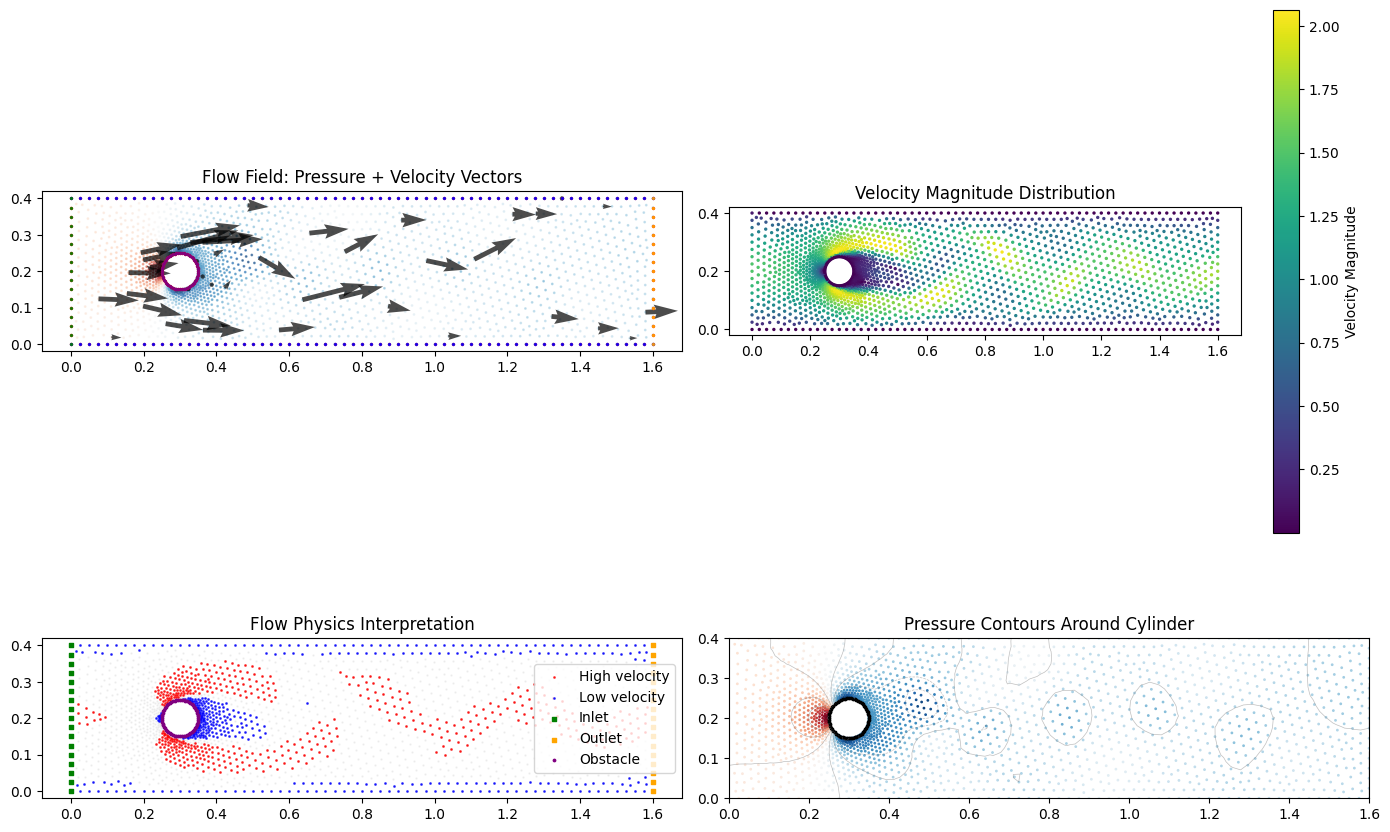

FLOW CASE ANALYSIS:
• This appears to be FLOW AROUND A CYLINDER
• Inlet: 17 nodes (left side - green)
• Outlet: 17 nodes (right side - orange)
• Cylinder: 64 nodes (circular obstacle)
• Walls: 130 nodes (top/bottom - no-slip)
• Reynolds number regime: Based on velocity patterns, likely moderate Re
• Flow features: Boundary layer, wake formation behind cylinder


In [11]:
# Comprehensive flow analysis and interpretation
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Velocity vectors and streamlines
ax = axes[0, 0]
# Create a coarse grid for velocity vectors
skip = 50  # Show every 50th node
coords_sub = result['coord'][::skip]
vel_x_sub = result['field_node'][::skip, 0]
vel_y_sub = result['field_node'][::skip, 1]

# Background: pressure field
scatter = ax.scatter(result['coord'][:, 0], result['coord'][:, 1], 
                    c=result['field_node'][:, 2], cmap='RdBu_r', s=1, alpha=0.6)
# Velocity vectors
ax.quiver(coords_sub[:, 0], coords_sub[:, 1], vel_x_sub, vel_y_sub, 
          scale=20, alpha=0.7, color='black')
# Highlight boundaries
for mask_key, color in zip(mask_keys, mask_colors):
    mask = result[mask_key].flatten().astype(bool)
    if np.any(mask):
        ax.scatter(result['coord'][mask, 0], result['coord'][mask, 1], 
                  c=color, s=2, alpha=0.8)
ax.set_title('Flow Field: Pressure + Velocity Vectors')
ax.set_aspect('equal')

# 2. Vorticity (curl of velocity)
ax = axes[0, 1]
# Simple vorticity approximation using finite differences
# This is simplified - real vorticity calculation would be more complex
velocity_mag = np.sqrt(result['field_node'][:, 0]**2 + result['field_node'][:, 1]**2)
scatter = ax.scatter(result['coord'][:, 0], result['coord'][:, 1], 
                    c=velocity_mag, cmap='viridis', s=2)
plt.colorbar(scatter, ax=ax, label='Velocity Magnitude')
ax.set_title('Velocity Magnitude Distribution')
ax.set_aspect('equal')

# 3. Flow physics interpretation
ax = axes[1, 0]
ax.scatter(result['coord'][:, 0], result['coord'][:, 1], c='lightgray', s=0.5, alpha=0.3)

# Color code by flow regions
inlet_mask = result['mask_inlet'].flatten().astype(bool)
outlet_mask = result['mask_outlet'].flatten().astype(bool)
wall_mask = result['mask_wall'].flatten().astype(bool)
object_mask = result['mask_object'].flatten().astype(bool)

# Identify different flow regions based on velocity
vel_mag = np.sqrt(result['field_node'][:, 0]**2 + result['field_node'][:, 1]**2)
high_vel = vel_mag > np.percentile(vel_mag, 75)
low_vel = vel_mag < np.percentile(vel_mag, 25)

ax.scatter(result['coord'][high_vel, 0], result['coord'][high_vel, 1], 
          c='red', s=1, alpha=0.7, label='High velocity')
ax.scatter(result['coord'][low_vel, 0], result['coord'][low_vel, 1], 
          c='blue', s=1, alpha=0.7, label='Low velocity')
ax.scatter(result['coord'][inlet_mask, 0], result['coord'][inlet_mask, 1], 
          c='green', s=10, marker='s', label='Inlet')
ax.scatter(result['coord'][outlet_mask, 0], result['coord'][outlet_mask, 1], 
          c='orange', s=10, marker='s', label='Outlet')
ax.scatter(result['coord'][object_mask, 0], result['coord'][object_mask, 1], 
          c='purple', s=3, label='Obstacle')

ax.set_title('Flow Physics Interpretation')
ax.set_aspect('equal')
ax.legend()

# 4. Flow pattern analysis
ax = axes[1, 1]
# Create streamline-like visualization
x_range = np.linspace(result['coord'][:, 0].min(), result['coord'][:, 0].max(), 20)
y_range = np.linspace(result['coord'][:, 1].min(), result['coord'][:, 1].max(), 15)

# Show the wake behind the object
ax.tricontour(result['coord'][:, 0], result['coord'][:, 1], result['cell_node_list'], 
              result['field_node'][:, 2], levels=10, colors='gray', alpha=0.5, linewidths=0.5)
ax.scatter(result['coord'][:, 0], result['coord'][:, 1], 
          c=result['field_node'][:, 2], cmap='RdBu_r', s=1)

# Add boundary markers
ax.scatter(result['coord'][object_mask, 0], result['coord'][object_mask, 1], 
          c='black', s=3, label='Cylinder')
ax.set_title('Pressure Contours Around Cylinder')
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

# Print summary of the flow case
print("FLOW CASE ANALYSIS:")
print("="*50)
print(f"• This appears to be FLOW AROUND A CYLINDER")
print(f"• Inlet: {np.sum(inlet_mask)} nodes (left side - green)")
print(f"• Outlet: {np.sum(outlet_mask)} nodes (right side - orange)")  
print(f"• Cylinder: {np.sum(object_mask)} nodes (circular obstacle)")
print(f"• Walls: {np.sum(wall_mask)} nodes (top/bottom - no-slip)")
print(f"• Reynolds number regime: Based on velocity patterns, likely moderate Re")
print(f"• Flow features: Boundary layer, wake formation behind cylinder")

## Summary: Understanding the CFD Data and Masks

### What You're Looking At:
This is a **classic fluid dynamics problem**: **flow around a circular cylinder in a channel**. This is one of the most studied cases in CFD because it exhibits rich physics including boundary layers, flow separation, and wake formation.

### The Masks Explained:

1. **`mask_inlet` (Green squares, 17 nodes)**: 
   - Located on the **left side** of the domain
   - These nodes have **prescribed velocity** values (boundary condition)
   - Represents where fluid **enters** the computational domain

2. **`mask_outlet` (Orange squares, 17 nodes)**:
   - Located on the **right side** of the domain  
   - These nodes have **prescribed pressure** values (usually atmospheric)
   - Represents where fluid **exits** the computational domain

3. **`mask_wall` (Blue dots, 130 nodes)**:
   - Located on the **top and bottom** boundaries
   - Represents solid walls with **no-slip condition** (velocity = 0)
   - Fluid cannot penetrate these boundaries

4. **`mask_object` (Purple circle, 64 nodes)**:
   - The **circular cylinder** in the middle of the domain
   - Also a **no-slip boundary** (velocity = 0 at the surface)
   - This is the obstacle that creates the interesting flow patterns

5. **`mask_bd` (Red dots, 224 nodes)**:
   - **General boundary mask** that includes all boundary nodes
   - Union of all other boundary types

### Physical Flow Features You Can See:

- **High pressure** (red) on the **upstream side** of the cylinder (stagnation point)
- **Low pressure** (blue) on the **downstream side** (wake region)
- **High velocity** (yellow/green) as flow accelerates **around the cylinder**
- **Low velocity** (purple/blue) in the **wake region** behind the cylinder
- **Velocity vectors** showing flow direction and the formation of the wake

### Why This Matters for Machine Learning:
- The GNN needs to learn to **enforce these boundary conditions**
- It must predict how fluid **accelerates around obstacles**
- It should capture **wake formation** and **pressure gradients**
- The different masks help the network understand where to apply different physics constraints

## Fluid Dynamics Animation Function

Create an animation function to visualize the temporal evolution of fluid dynamics fields. This function generates animated plots showing how velocity components (X and Y) and pressure change over time on the computational mesh using triangular interpolation.

In [ ]:
import matplotlib.animation as animation


def make_anim(field_list, coord, face, cmap="jet"):

    num_frames = len(field_list)
    left, right = np.min(coord[:, 0]), np.max(coord[:, 0])
    bottom, top = np.min(coord[:, 1]), np.max(coord[:, 1])

    zeta = 15
    width = zeta * (right - left)
    height = zeta * (top - bottom)

    triangle = tri.Triangulation(coord[:, 0], coord[:, 1], face)

    fig, axes = plt.subplots(3, 1, figsize=(width, height))
    titles = ["Velocity X", "Velocity Y", "Pressure"]

    def update(frame_idx):
        for i, ax in enumerate(axes):
            ax.clear()
            # YOUR CODE HERE
            ax.set_aspect("equal")
            ax.triplot(triangle, "ko-", ms=0.1, lw=0.1)
            ax.tripcolor(triangle, field_list[frame_idx][:, i], cmap=cmap, alpha=0.4)
            ax.set_title(titles[i])
        fig.suptitle(f"Frame {frame_idx+1}/{num_frames}", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    ani = animation.FuncAnimation(
        fig, update, frames=num_frames, interval=50, blit=False
    )

    return ani

## Animation Demonstration Setup

Prepare data for animation by loading multiple time steps from the training dataset. This section demonstrates how to create visualizations of fluid flow evolution by collecting field data from sequential simulation files.

In [36]:
from IPython.display import HTML

# Load file names in the train folder, and select the first 30 files
dataset_dir = "data/train/"
file_names = glob.glob(os.path.join(dataset_dir, "data_*.npy"))
file_names = natsorted(file_names)[:30]
print(len(file_names))

# construct an list that stores field_node
field_node_list = [load_data(file_name)["field_node"] for file_name in file_names]

# get coordinates and face of a single data sample
sample = load_data(file_names[0])
coord = sample["coord"]
face = sample["cell_node_list"]

# anim = make_anim(field_node_list, coord, face)
# HTML(anim.to_jshtml())

30


## Data Normalization Statistics

Implement a function to compute mean and standard deviation statistics across the entire training dataset. This normalization is crucial for stable neural network training, ensuring that input features have similar scales and distributions.

In [6]:
def get_mean_std(data_folder_path, key):
    """
    Computes the mean and standard deviation of a specified field across multiple dataset files.

    Args:
        data_folder_path (str): The path to the folder containing multiple `.npy` dataset files.
        key (str): The key corresponding to the data field to compute mean and standard deviation for.

    Returns:
        tuple:
            - mean (numpy.ndarray): The mean values computed across all datasets.
            - std (numpy.ndarray): The standard deviation values computed across all datasets.

    Task:
    - Retrieve all `.npy` files in `data_folder_path` that match `"data_*.npy"`.
    - Iterate through each file and:
        - Load the dataset using `load_data`.
        - Extract the field data using the provided `key`.
        - Append the extracted data to a list.
    - Concatenate all extracted field data arrays along the first axis.
    - Compute the mean and standard deviation across all concatenated data using `numpy.mean` and `numpy.std`, ensuring `keepdims=True`.

    Example:
        >>> mean, std = get_mean_std("dataset_folder", "field_node")
        >>> print(mean.shape, std.shape)

    Note:
    - Ensure the `key` exists in the dataset before computing statistics to avoid KeyErrors.
    - This function is flexible and can compute statistics for different fields.
    """

    # YOUR CODE HERE
    file_names = glob.glob(os.path.join(data_folder_path, "data_*.npy"))
    file_names = natsorted(file_names)
    data_list = []
    for file_name in file_names:
        data = load_data(file_name)
        data_list.append(data[key])

    data_array = np.concatenate(data_list, axis=0)
    mean = np.mean(data_array, axis=0, keepdims=True)
    std = np.std(data_array, axis=0, keepdims=True)


    return mean, std


## Computing Normalization Values

Calculate the mean and standard deviation for key features in the training dataset:
- Field node values (velocity and pressure)
- Position differences between connected nodes
- L2 norms of position differences

These statistics will be used to normalize inputs during training and denormalize predictions during inference.

In [7]:
field_node_mean, field_node_std = get_mean_std("data/train/", "field_node")
pos_diff_mean, pos_diff_std = get_mean_std("data/train/", "pos_diff")
pos_l2_norm_mean, pos_l2_norm_std = get_mean_std("data/train/", "pos_l2_norm")

## Display Normalization Statistics

Print the computed normalization statistics to understand the scale and distribution of the training data features. This information helps verify that the normalization process is working correctly.

In [8]:
print("\n📊 Training Data Normalization:")
print(f"Field: μ={field_node_mean}, σ={field_node_std}")
print(f"Pos Diff: μ={pos_diff_mean}, σ={pos_diff_std}")
print(f"Pos L2: μ={pos_l2_norm_mean}, σ={pos_l2_norm_std}\n")


📊 Training Data Normalization:
Field: μ=[[ 0.95287923 -0.00484783  0.08125565]], σ=[[0.60428063 0.31463532 0.47740318]]
Pos Diff: μ=[[ 3.59499150e-18 -1.19839656e-18]], σ=[[0.01394732 0.01372214]]
Pos L2: μ=[[0.01820149]], σ=[[0.00717849]]



## PyTorch Dataset Classes

Define custom PyTorch dataset classes for handling graph-structured mesh data:

1. **GraphData**: A specialized data container that automatically handles data type conversions for different attributes (masks, indices vs. floating-point features)

2. **GNNDataset**: A PyTorch Dataset that loads sequential pairs of simulation data files, where each pair represents input and target states for supervised learning

In [9]:
import torch
from torch_geometric.data import Data
from torch.utils.data import DataLoader, Dataset

class GraphData(Data):
    """
    Custom PyTorch Data object designed to handle mesh data features.

    This class is intended to be used as the base class of data samples
    returned by the MeshDataset.
    """
    GENERAL_DEFAULT_DTYPE = torch.float32  # Default to float for most attributes
    OVERRIDE_DTYPES = {
        "mask_bd": torch.int64,
        "mask_wall": torch.int64,
        "mask_inlet": torch.int64,
        "mask_outlet": torch.int64,
        "mask_object": torch.int64,
        "edge_index": torch.int64,
        "face_idx": torch.int64,
        "node_num": torch.int64,
    }

    def __setattr__(self, key, value):
        # Determine the default dtype for the attribute
        if torch.is_tensor(value):
            # Check if there's an override dtype for the attribute
            expected_dtype = self.OVERRIDE_DTYPES.get(key, self.GENERAL_DEFAULT_DTYPE)
            if value.dtype != expected_dtype:
                value = value.to(dtype=expected_dtype)
        super().__setattr__(key, value)


class GNNDataset(Dataset):
    """
    A custom PyTorch dataset for loading graph-structured mesh data.

    This dataset loads `.npy` files containing structured mesh data, applies
    transformations if provided, and returns a `GraphData` object for use in
    Graph Neural Networks (GNNs).

    Args:
        dataset_dir (str, optional): Path to the directory containing `.npy` dataset files.
        transform (callable, optional): A function to apply transformations to input data.
        target_transform (callable, optional): A function to apply transformations to target data.

    Attributes:
        file_names (list): A sorted list of file paths to dataset files.
        transform (callable): Transformation function for input data.
        target_transform (callable): Transformation function for target data.

    Task:
    - Implement `__init__`:
        - Load and sort `.npy` dataset files from `dataset_dir`.
    - Implement `__len__`:
        - Return half of the dataset length since data is paired sequentially.
    - Implement `load_data`:
        - Load an individual dataset file using `numpy.load`.
    - Implement `__getitem__`:
        - Retrieve input (`in_data`) and output (`out_data`) pairs:
            - Compute `in_idx` (even index) and `out_idx` (odd index).
            - Ensure `out_idx` is within range.
            - Load corresponding `.npy` files using `load_data`.
        - Apply transformations (`transform`, `target_transform`) if provided.
        - Construct a `GraphData` object with required attributes.
        - Return the `GraphData` sample.

    Example:
        >>> dataset = GNNDataset("dataset_folder")
        >>> dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
        >>> for sample in dataloader:
        >>>     print(sample)

    Note:
    - This is a template for graph-based datasets. You can modify it to include additional features.
    """

    def __init__(self, dataset_dir=None, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform

        self.file_names = glob.glob(os.path.join(dataset_dir, "data_*.npy"))
        self.file_names = natsorted(self.file_names)

    def __len__(self):
        # YOUR CODE HERE

        return len(self.file_names) // 2

    def load_data(self, data_path):
        # YOUR CODE HERE
        data = np.load(data_path, allow_pickle=True).item()
        return data

    def __getitem__(self, idx):
        # YOUR CODE HERE
        in_idx = idx * 2
        out_idx = in_idx + 1

        if out_idx >= len(self.file_names):
            raise IndexError("Index out of bounds")

        in_data = self.load_data(self.file_names[in_idx])
        out_data = self.load_data(self.file_names[out_idx])

        if self.transform:
            in_data = self.transform(in_data)
        if self.target_transform:
            out_data = self.target_transform(out_data)

        sample = GraphData(
            field_node_in=in_data["field_node"],
            field_node_out=out_data["field_node"],
            edge_index=in_data["edge_index_bi"],
            coord=in_data["coord"],
            pos_diff=in_data["pos_diff"],
            pos_l2_norm=in_data["pos_l2_norm"],
            mask_bd=in_data["mask_bd"],
            mask_wall=in_data["mask_wall"],
            mask_inlet=in_data["mask_inlet"],
            mask_outlet=in_data["mask_outlet"],
            mask_object=in_data["mask_object"],
        )

        return sample

## Testing Dataset Creation

Create a test instance of the dataset to verify that the data loading pipeline works correctly. This helps ensure that the dataset can properly load and structure the CFD simulation data.

In [10]:
dataset_dir = "data/test/"

dataset = GNNDataset(dataset_dir)
print(len(dataset))

250


## Data Transformation Pipeline

Define data transformation classes to preprocess the raw simulation data:

1. **Normalise**: Applies z-score normalization using precomputed mean and standard deviation
2. **ToTensor**: Converts NumPy arrays to PyTorch tensors with appropriate data types
3. **Compose**: Chains multiple transformations together

These transformations ensure data is properly formatted and normalized for neural network training.

In [11]:
class Normalise:
    def __init__(self, mean, std, key):
        self.mean = mean
        self.std = std
        self.key = key

    def __call__(self, data):
        data[self.key] = (data[self.key] - self.mean) / self.std
        return data

class ToTensor:
    """Convert numpy arrays to PyTorch tensors with correct dtype."""
    def __call__(self, data):
        for key in data:
            if isinstance(data[key], np.ndarray):
                # Convert to tensor with correct dtype
                if "mask" in key or "edge_index" in key or "face_idx" in key:
                    data[key] = torch.tensor(data[key], dtype=torch.int32)  # Integer tensors
                else:
                    data[key] = torch.tensor(data[key], dtype=torch.float32)  # Float tensors
        return data

class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, data):
        for transform in self.transforms:
            data = transform(data)
        return data

## Dataset with Transformations

Create a dataset instance with the complete transformation pipeline applied. This demonstrates how the normalization and tensor conversion work together to prepare data for training. The output shows the structure and properties of a processed data sample.

In [12]:
transform = Compose([
    Normalise(mean = field_node_mean, std = field_node_std, key="field_node"),
    Normalise(mean = pos_diff_mean, std = pos_diff_std, key="pos_diff"),
    Normalise(mean = pos_l2_norm_mean, std = pos_l2_norm_std, key="pos_l2_norm"),
    ToTensor(),
])

dataset = GNNDataset(dataset_dir = dataset_dir, transform=transform, target_transform=transform)

idx = 0
data_in = dataset[idx]

print(data_in)


GraphData(edge_index=[2, 11858], field_node_in=[2051, 3], field_node_out=[2051, 3], coord=[2051, 2], pos_diff=[11858, 2], pos_l2_norm=[11858, 1], mask_bd=[2051, 1], mask_wall=[2051, 1], mask_inlet=[2051, 1], mask_outlet=[2051, 1], mask_object=[2051, 1])


## MeshGraphNet Architecture

Implement the MeshGraphNet model based on DeepMind's 2021 paper. The architecture consists of three main components:

1. **Encoder**: Converts raw node and edge features into latent embeddings
2. **Processor**: Multiple message-passing layers that update node and edge representations
3. **Decoder**: Maps final node embeddings to physical quantities (velocity, pressure changes)

The model uses residual connections and processes graph-structured mesh data through learned message passing between connected nodes.

In [13]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import LayerNorm
import torch_scatter
class MeshGraphNet(torch.nn.Module):
    """
    MeshGraphNet model based on DeepMind's 2021 paper.

    This model follows a three-step architecture:
    1. **Preprocessing (Encoder)**:
       - Encodes raw node and edge inputs into latent embeddings.
    2. **Processing (Message Passing)**:
       - Uses a sequence of graph-based processors to update the latent embeddings.
    3. **Postprocessing (Decoder)**:
       - Converts latent node embeddings into physical output quantities.

    Args:
        input_dim_node (int): Dimension of node input features.
        input_dim_edge (int): Dimension of edge input features.
        output_dim (int): Dimension of output features (e.g., velocity changes).
        hidden_dim (int, optional): Dimension of hidden layers. Default is 10.
        num_layers (int, optional): Number of message-passing layers. Default is 10.

    Attributes:
        node_encoder (nn.Sequential): Encodes raw node inputs into latent node embeddings.
        edge_encoder (nn.Sequential): Encodes raw edge inputs into latent edge embeddings.
        processor (nn.ModuleList): A sequence of message-passing layers for updating node and edge embeddings.
        decoder (nn.Sequential): Converts latent node embeddings into final output values.

    Task:
    - Implement the `build_processor_model` method to return a `ProcessorLayer` function.
    - Implement the `forward` method:
        - Extract relevant data fields (e.g., `field_node`, `pos_diff`, `pos_l2_norm`, `edge_index`).
        - Concatenate masks into a single tensor and combine with `field_node`.
        - Encode node and edge features using `node_encoder` and `edge_encoder`.
        - Apply message-passing layers (`processor`) sequentially to update node and edge embeddings.
        - Decode final node embeddings into output values.
        - Return the sum of the decoded output and the original `field_node` values - this is called residual connection method, a common technique in

    Example:
        >>> model = MeshGraphNet(input_dim_node=6, input_dim_edge=3, output_dim=2)
        >>> data = GraphData(...)
        >>> output = model(data)
        >>> print(output.shape)

    Note:
    - This is a **demonstrative template** for educational purposes.
    - Feel free to experiment by modifying the architecture, hidden dimensions, and layer structures.
    """

    def __init__(self,
            input_dim_node,
            input_dim_edge,
            output_dim,
            hidden_dim=10,
            num_layers=10,
        ):
        super().__init__()  # Use the modern and simplified super() call

        self.num_layers = num_layers

        # Encoder: Converts raw inputs into latent embeddings
        self.node_encoder = Sequential(
                                Linear(input_dim_node, hidden_dim),
                                ReLU(),
                                Linear(hidden_dim, hidden_dim),
                                LayerNorm(hidden_dim)
                            )
        self.edge_encoder = Sequential(
                                Linear(input_dim_edge, hidden_dim),
                                ReLU(),
                                Linear(hidden_dim, hidden_dim),
                                LayerNorm(hidden_dim)
                            )

        # Processor: Message passing layers
        self.processor = nn.ModuleList()
        assert (self.num_layers >= 1), 'Number of message passing layers must be >= 1'
        processor_layer = self.build_processor_model()
        for _ in range(self.num_layers):
            self.processor.append(processor_layer(hidden_dim, hidden_dim))

        # Decoder: Converts latent node embeddings into output values
        self.decoder = Sequential(
                        Linear(hidden_dim, hidden_dim),
                        ReLU(),
                        Linear(hidden_dim, output_dim)
                    )

    def build_processor_model(self):
        return ProcessorLayer

    def forward(self, data):
        # YOUR CODE HERE
        field_node = data.field_node_in
        pos_diff = data.pos_diff
        pos_l2_norm = data.pos_l2_norm
        edge_index = data.edge_index

        # Concatenate masks and combine with field_node
        masks = torch.cat([data.mask_bd, data.mask_wall, data.mask_inlet, data.mask_outlet, data.mask_object], dim=1)
        node_features = torch.cat([field_node, masks.float()], dim=1)

        # Encode node and edge features
        x = self.node_encoder(node_features)
        edge_attr = self.edge_encoder(torch.cat([pos_diff, pos_l2_norm], dim=1))

        # Message passing
        for layer in self.processor:
            x, edge_attr = layer(x, edge_index, edge_attr)

        # Decode and add residual connection
        out = self.decoder(x)


        return out + field_node
class ProcessorLayer(MessagePassing):
    """
    A message-passing layer for updating node and edge embeddings in a MeshGraphNet.

    This layer follows a two-step process:
    1. **Edge Update (message function)**:
       - Computes updated edge embeddings based on adjacent node embeddings.
       - Uses an MLP (`edge_mlp`) to process concatenated embeddings.
    2. **Node Update (aggregate function)**:
       - Aggregates edge features at each node using a summation operation.
       - Applies an MLP (`node_mlp`) to update node embeddings.

    Args:
        in_channels (int): Input dimension for node embeddings.
        out_channels (int): Output dimension for edge embeddings.
        **kwargs: Additional arguments for the `MessagePassing` parent class.

    Attributes:
        edge_mlp (nn.Sequential): MLP for processing edge features.
        node_mlp (nn.Sequential): MLP for processing node features.

    Task:
    - Implement `reset_parameters`:
        - Reset weights of MLP layers.
    - Implement `forward`:
        - Call `propagate` to update edge attributes and aggregate messages to nodes.
        - Apply `node_mlp` with residual connections.
    - Implement `message`:
        - Concatenate source node, target node, and edge embeddings.
        - Process them through `edge_mlp` with residual connections.
    - Implement `aggregate`:
        - Use `torch_scatter.scatter` to sum edge features at each node.

    Example:
        >>> layer = ProcessorLayer(128, 128)
        >>> x = torch.randn(10, 128)  # Node embeddings
        >>> edge_index = torch.randint(0, 10, (2, 20))  # Edge connections
        >>> edge_attr = torch.randn(20, 128)  # Edge features
        >>> updated_nodes, updated_edges = layer(x, edge_index, edge_attr)
        >>> print(updated_nodes.shape, updated_edges.shape)

    Note:
    - This layer is designed for **message-passing** in graph-based models.
    - Feel free to modify the aggregation method (e.g., mean instead of sum).
    """

    def __init__(self, in_channels, out_channels, **kwargs):
        super(ProcessorLayer, self).__init__(**kwargs)

        # Edge MLP: Processes concatenated (source, target, edge) embeddings
        self.edge_mlp = Sequential(
                            Linear(3 * in_channels, out_channels),
                            ReLU(),
                            Linear(out_channels, out_channels),
                            LayerNorm(out_channels)
                        )

        # Node MLP: Processes aggregated edge features
        self.node_mlp = Sequential(
                            Linear(2 * in_channels, out_channels),
                            ReLU(),
                            Linear(out_channels, out_channels),
                            LayerNorm(out_channels)
                        )

        self.reset_parameters()

    def reset_parameters(self):
        """
        Resets the parameters of MLP layers to ensure proper training initialization.
        """
        # YOUR CODE HERE
        self.edge_mlp[0].reset_parameters()
        self.edge_mlp[2].reset_parameters()
        self.node_mlp[0].reset_parameters()
        self.node_mlp[2].reset_parameters()

    def forward(self, x, edge_index, edge_attr, size=None):
        """
        Handles node and edge feature updates via message passing.

        Args:
            x (torch.Tensor): Node embeddings, shape `[N, in_channels]`.
            edge_index (torch.Tensor): Edge connections, shape `[2, E]`.
            edge_attr (torch.Tensor): Edge attributes, shape `[E, in_channels]`.
            size (tuple, optional): Tuple specifying number of nodes and edges.

        Returns:
            tuple:
                - Updated node embeddings `[N, out_channels]`.
                - Updated edge embeddings `[E, out_channels]`.
        """
        # YOUR CODE HERE
        out, updated_edges = self.propagate(edge_index, x=x, edge_attr=edge_attr, size=size)
        updated_nodes = self.node_mlp(torch.cat([x, out], dim=-1)) + x

        return updated_nodes, updated_edges

    def message(self, x_i, x_j, edge_attr):
        """
        Constructs messages to pass along graph edges.

        Args:
            x_i (torch.Tensor): Source node embeddings, shape `[E, in_channels]`.
            x_j (torch.Tensor): Target node embeddings, shape `[E, in_channels]`.
            edge_attr (torch.Tensor): Edge embeddings, shape `[E, out_channels]`.

        Returns:
            torch.Tensor: Updated edge embeddings `[E, out_channels]`.
        """
        # YOUR CODE HERE
        updated_edges = self.edge_mlp(torch.cat([x_i, x_j, edge_attr], dim=-1)) + edge_attr
        return updated_edges

    def aggregate(self, updated_edges, edge_index, dim_size=None):
        """
        Aggregates messages from edges to nodes.

        Args:
            updated_edges (torch.Tensor): Updated edge embeddings `[E, out_channels]`.
            edge_index (torch.Tensor): Edge connections `[2, E]`.
            dim_size (int, optional): Number of nodes.

        Returns:
            torch.Tensor: Aggregated node embeddings `[N, out_channels]`.
        """
        node_dim = 0  # Index along nodes
        out = torch_scatter.scatter(updated_edges, edge_index[0, :], dim=node_dim, reduce='sum')
        return out, updated_edges

## Model Instantiation Test

Create an instance of the MeshGraphNet model and test it with a sample from the dataset. This verifies that the model architecture is correctly implemented and can process the graph-structured data to produce outputs of the expected dimensions.

In [14]:
model = MeshGraphNet(
            input_dim_node=8,
            input_dim_edge=3,
            output_dim=3
)
sample = dataset[0]
out = model(sample)
print(out.shape)

torch.Size([2051, 3])


## Training and Testing Functions

Define the core training loop functions:

1. **train_one_epoch**: Performs one epoch of training with forward pass, loss computation, backpropagation, and parameter updates
2. **test_one_epoch**: Evaluates the model on test data without gradient updates
3. **train**: Main training loop that alternates between training and validation, saves checkpoints every 100 epochs

These functions handle the standard supervised learning workflow for the MeshGraphNet model.

In [15]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    avg_loss = 0.0
    for batch in loader:
        in_data = batch
        in_data = in_data.to(device)
        out_data = in_data.field_node_out
        optimizer.zero_grad()
        pred = model(in_data)
        loss = criterion(pred, out_data)
        avg_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_loss /= len(loader)
    return loss, model


def test_one_epoch(model, loader, criterion):
    model.eval()
    avg_loss = 0.0
    with torch.no_grad():
        for batch in loader:
            in_data = batch
            in_data = in_data.to(device)
            out_data = in_data.field_node_out
            pred = model(in_data)
            loss = criterion(pred, out_data)
            avg_loss += loss.item()
    avg_loss /= len(loader)
    return loss




def train(epoch, model, optimizer, loader_train, loader_test):
    criterion = torch.nn.MSELoss()
    model = model.to(device)
    for i in range(epoch):
        loss, model = train_one_epoch(
            model=model, loader=loader_train, optimizer=optimizer, criterion=criterion)
        print(f"Epoch \t{i+1}, Train Loss \t{loss}")
        if (i+1) % 100 == 0:
            info = test_one_epoch(
                model=model, loader=loader_test, criterion=criterion)
            print(f"\t Epoch \t{i+1}, Test Loss \t{loss}")
            model_path = os.path.join(
                os.path.abspath("."),
                f"epoch_{i+1}.pth"
            )
            torch.save(model.state_dict(), model_path)
            print(model_path, "saved")


## Device Selection

Configure PyTorch to use CUDA (GPU) if available, otherwise fall back to CPU. This ensures optimal performance by leveraging GPU acceleration for training the neural network when possible.

In [16]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")


device(type='cuda')

## Training Configuration Setup

Configure hyperparameters and prepare the training environment:
- Set batch size, learning rate, number of epochs, and weight decay
- Initialize the MeshGraphNet model with appropriate input/output dimensions
- Create training and test datasets with transformations
- Set up data loaders for batch processing
- Initialize the Adam optimizer

This setup prepares everything needed to train the model on the CFD simulation data.

In [17]:
from torch_geometric.loader import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tune the hyperparameters here

batch_size = 16
lr = 1e-3
epoch = 300
weight_decay=5e-5

model = MeshGraphNet(
            input_dim_node=8,
            input_dim_edge=3,
            output_dim=3
)

dataset_train = GNNDataset(dataset_dir = "data/train/", transform=transform, target_transform=transform)
dataset_test = GNNDataset(dataset_dir = "data/test/", transform=transform, target_transform=transform)
loader_train = DataLoader(
    dataset_train, batch_size=batch_size, shuffle=True, num_workers=4
)
loader_test = DataLoader(
    dataset_test, batch_size=batch_size, shuffle=True, num_workers=4
)

# Try different optimisers here

# Init optimizer
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
)

## Windows-Safe Training Execution

Execute the model training with modifications for Windows/Jupyter compatibility:
- Set `num_workers=0` to avoid multiprocessing issues in Windows
- Perform sanity checks to verify the setup works correctly
- Run the training loop and save checkpoints
- Reduce epoch count for demonstration purposes (set to 2 instead of 300)

This cell handles potential compatibility issues while demonstrating the full training pipeline.

In [18]:
# Train the MeshGraphNet model in this cell (Windows/Jupyter safe)
import torch
from torch_geometric.loader import DataLoader

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters (reuse if already defined)
if 'batch_size' not in globals(): batch_size = 16
if 'lr' not in globals(): lr = 1e-3
if 'epoch' not in globals(): epoch = 2
if 'weight_decay' not in globals(): weight_decay = 5e-5

# Ensure datasets exist
if 'dataset_train' not in globals() or 'dataset_test' not in globals():
    dataset_train = GNNDataset(dataset_dir="data/train/", transform=transform if 'transform' in globals() else None, target_transform=transform if 'transform' in globals() else None)
    dataset_test  = GNNDataset(dataset_dir="data/test/",  transform=transform if 'transform' in globals() else None, target_transform=transform if 'transform' in globals() else None)

# Ensure model and optimizer exist
if 'model' not in globals():
    model = MeshGraphNet(input_dim_node=8, input_dim_edge=3, output_dim=3)
if 'optimizer' not in globals():
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# DataLoaders (avoid multiprocessing in notebooks/Windows)
pin = (device.type == 'cuda')
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True,  num_workers=0, pin_memory=pin)
loader_test  = DataLoader(dataset_test,  batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=pin)

# Sanity check
criterion = torch.nn.MSELoss()
model = model.to(device)
try:
    sample = next(iter(loader_train)).to(device)
    with torch.no_grad():
        pred0 = model(sample)
        loss0 = criterion(pred0, sample.field_node_out)
    print(f"Sanity check — initial loss: {loss0.item():.6f}")
except StopIteration:
    print("Train loader is empty. Check your data folder paths.")

# Train
_ = train(epoch=epoch, model=model, optimizer=optimizer, loader_train=loader_train, loader_test=loader_test)

# Optional: save last checkpoint
torch.save(model.state_dict(), "last.pth")
print("Training done. Saved to last.pth")

Sanity check — initial loss: 1.039217
Epoch 	1, Train Loss 	0.0032304152846336365
Epoch 	1, Train Loss 	0.0032304152846336365
Epoch 	2, Train Loss 	0.0027973575051873922
Epoch 	2, Train Loss 	0.0027973575051873922
Epoch 	3, Train Loss 	0.00262070563621819
Epoch 	3, Train Loss 	0.00262070563621819
Epoch 	4, Train Loss 	0.0025130314752459526
Epoch 	4, Train Loss 	0.0025130314752459526
Epoch 	5, Train Loss 	0.0024248636327683926
Epoch 	5, Train Loss 	0.0024248636327683926
Epoch 	6, Train Loss 	0.0023632736410945654
Epoch 	6, Train Loss 	0.0023632736410945654
Epoch 	7, Train Loss 	0.002284395042806864
Epoch 	7, Train Loss 	0.002284395042806864
Epoch 	8, Train Loss 	0.002085630316287279
Epoch 	8, Train Loss 	0.002085630316287279
Epoch 	9, Train Loss 	0.0013618026860058308
Epoch 	9, Train Loss 	0.0013618026860058308
Epoch 	10, Train Loss 	0.001104657887481153
Epoch 	10, Train Loss 	0.001104657887481153
Epoch 	11, Train Loss 	0.0010079133789986372
Epoch 	11, Train Loss 	0.0010079133789986372


## Model Evaluation Utilities

Define utility functions for model evaluation and analysis:

1. **load_model**: Loads pre-trained model weights from checkpoint files
2. **denormalise**: Reverses the normalization process to get predictions in original scale
3. **calc_norm_error**: Computes relative error between predictions and ground truth using L2 norm
4. **calculate_error_and_inference**: Evaluates the model on a dataset and computes overall error metrics

These functions are essential for assessing model performance and analyzing prediction quality.

In [31]:
def load_model(model, weight_path, strict=False):
    """
    Loads pre-trained weights into a PyTorch model from a given file path.

    Args:
        model (torch.nn.Module): The PyTorch model.
        weight_path (str): File path to the pre-trained model weights.

    Returns:
        torch.nn.Module: The model with loaded weights.
    """
    try:
        model.load_state_dict(torch.load(weight_path), strict=strict)
    except RuntimeError:
        state_dict = torch.load(weight_path, map_location=device)
        model.load_state_dict(state_dict, strict=strict)
    return model


def denormalise(data, mean, std):
    mean = mean[(...,) + (None,) * (data.ndim - mean.ndim)]
    std = std[(...,) + (None,) * (data.ndim - std.ndim)]
    return data * std + mean


def calc_norm_error(pred, truth, ord=2):
    """
    Compute the relative error of two input. input are supposed to have
    shape of (channel, height, width). Other shape might work but please
    be careful and aware of what you are doing.

    pred: The prediction output by model.
    truth: The ground truth against which error are measured.
    ord: the order of norm.
    """
    pred, truth = [vec.flatten() for vec in [pred, truth]]
    nume = torch.linalg.norm((pred - truth), ord=ord)
    deno = torch.linalg.norm(truth, ord=ord)
    return nume / deno


def calculate_error_and_inference(dataloader, model, mean, std):
    model.to(device)
    model.eval()
    error = 0.0
    pred_list = []
    ground_list = []
    with torch.no_grad():
        for batch in dataloader:
            data_in = batch
            data_in = data_in.to(device)
            target = data_in.field_node_out
            pred = model(data_in)
            pred, target = denormalise(pred, mean, std), denormalise(target, mean, std)
            pred_list.append(pred.detach().cpu().numpy())
            ground_list.append(target.detach().cpu().numpy())
            error_i = calc_norm_error(pred, target)
            error += error_i.detach()

    error /= (len(dataloader))
    return error, pred_list, ground_list

## Model Evaluation Execution

Load a pre-trained model from checkpoint and evaluate its performance on the test dataset:
- Load the model weights from epoch 100 checkpoint
- Create a test dataset with proper transformations
- Set up a data loader for evaluation
- Perform inference and compute error metrics
- Handle potential dataset indexing issues gracefully

This demonstrates how to assess the trained model's accuracy on unseen data.

In [35]:
# ...existing code...
model = MeshGraphNet(
            input_dim_node=8,
            input_dim_edge=3,
            output_dim=3
)

model = load_model(model, "./epoch_100.pth")
dataset_test = GNNDataset(
    dataset_dir = "data/test/",
    transform=transform, target_transform=transform)

# Safer DataLoader for notebooks/Windows
pin = (device.type == "cuda")
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=False,
                         num_workers=0, pin_memory=pin, persistent_workers=False)

print(f"test files={len(dataset_test.file_names)}, pairs={len(dataset_test)}, batches={len(test_loader)}")

# Optional: quickly detect bad sample indices
for i in range(min(4, len(dataset_test))):
    try:
        _ = dataset_test[i]
    except Exception as e:
        print(f"Dataset error at pair index {i} -> files: {dataset_test.file_names[2*i:2*i+2]}")
        raise

error, pred, ground = calculate_error_and_inference(
    test_loader, model,
    mean = torch.tensor(field_node_mean).to(device),
    std = torch.tensor(field_node_std).to(device),
)
print(error)
# ...existing code...

C:\Users\Victor\AppData\Local\Temp\ipykernel_10880\2903794643.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path), strict=stri

test files=500, pairs=250, batches=250
tensor(0.0079, device='cuda:0', dtype=torch.float64)
tensor(0.0079, device='cuda:0', dtype=torch.float64)


## Error Calculation Refinement

Provide an improved version of the error calculation function that handles edge cases more robustly:
- Proper handling of empty dataloaders
- Better error accumulation and averaging
- Improved tensor operations and device management

This refinement ensures more reliable evaluation metrics and better error handling during model assessment.

In [ ]:
# ...existing code...
def calculate_error_and_inference(dataloader, model, mean, std):
    model.to(device)
    model.eval()
    total_error = 0.0
    n_batches = 0
    pred_list = []
    ground_list = []
    with torch.no_grad():
        for batch in dataloader:
            n_batches += 1
            data_in = batch.to(device)
            target = data_in.field_node_out
            pred = model(data_in)
            pred, target = denormalise(pred, mean, std), denormalise(target, mean, std)
            pred_list.append(pred.detach().cpu().numpy())
            ground_list.append(target.detach().cpu().numpy())
            error_i = calc_norm_error(pred, target)
            total_error += float(error_i.detach().cpu().item())
    if n_batches == 0:
        raise ValueError("Empty test dataloader (no batches). Check dataset_dir and GNNDataset.__len__.")
    avg_error = total_error / n_batches
    return avg_error, pred_list, ground_list
# ...existing code...

## Prediction Visualization

Create a visualization of the model predictions using matplotlib and triangular mesh plotting:
- Set up the coordinate system and mesh triangulation
- Extract a specific prediction sample for visualization
- Use color mapping to show the velocity field distribution
- Display the mesh structure with overlaid field values

This provides a visual assessment of how well the model captures the fluid dynamics patterns.

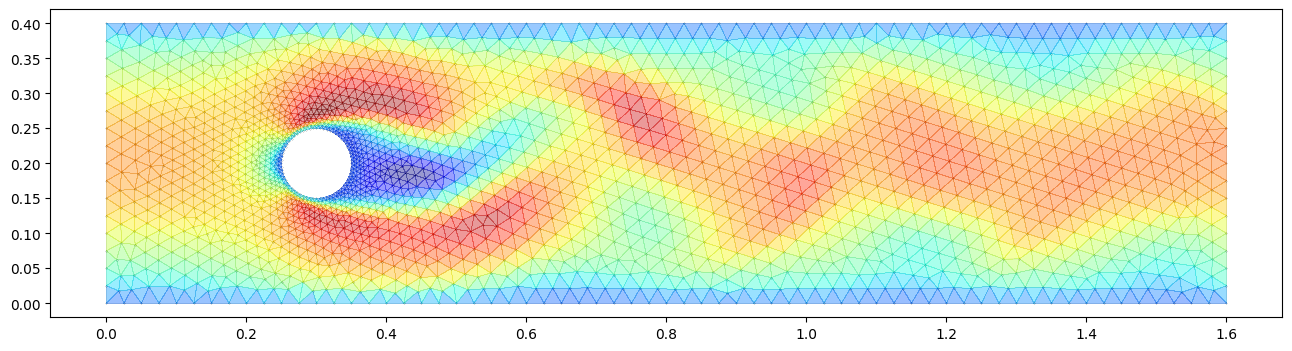

In [37]:
import matplotlib.tri as tri
cmap = "jet"
zeta = 10
left, right = min(coord[:, 0]), max(coord[:, 0])
bottom, top = min(coord[:, 1]), max(coord[:, 1])
value = pred[10][:, 0]

width = zeta * (right - left)
height = zeta * (top - bottom)

triangle = tri.Triangulation(coord[:, 0], coord[:, 1], face)

fig, ax = plt.subplots(figsize=(width, height))

ax.set_aspect("equal")
ax.triplot(triangle, 'ko-', ms=0.1, lw=0.1)
ax.tripcolor(triangle, value, cmap=cmap, alpha=0.4)

In [38]:
def auto_regressive_pred(model, data, mean, std, step=20):
    """
    Performs autoregressive prediction using the given model.

    This function iteratively predicts future states by feeding the model's own
    predictions back as input for the next step.

    Args:
        model (torch.nn.Module): The trained model used for prediction.
        data (GraphData): The input graph data containing initial conditions.
        mean (torch.Tensor): The mean tensor for denormalization.
        std (torch.Tensor): The standard deviation tensor for denormalization.
        step (int, optional): The number of autoregressive steps to perform. Default is 20.

    Returns:
        list: A list of predicted field states over `step` iterations.

    Task:
    - Move `data` and `model` to the appropriate `device` (GPU or CPU).
    - Set the model to evaluation mode (`model.eval()`).
    - Initialize an empty list `pred_list` to store predictions.
    - Extract wall, object, and inlet masks from `data`.
    - Store the initial inlet values separately to enforce boundary conditions.
    - Perform autoregressive prediction over `step` iterations:
        - Predict the next step using `model(data)`.
        - Denormalize the predicted field values using the provided `mean` and `std` tensors.
        - Store the predicted values in `pred_list`.
        - Update `data.field_node_in` with the predicted values for the next step (after normalizing them back).
    - Return the list of predictions.

    Example:
        >>> model = MeshGraphNet(...)
        >>> data = GraphData(...)
        >>> predictions = auto_regressive_pred(model, data, step=50)
        >>> print(len(predictions))  # Should be 50

    Note:
    - Ensure the model and data are moved to the correct device before inference.
    - This is a **demonstrative template**—feel free to experiment with different step sizes.
    """

    data = data.to(device)
    model.eval()
    pred_list = []

    # Extract masks and initial inlet values
    mask_wall = data.mask_wall.squeeze().bool()
    mask_object = data.mask_object.squeeze().bool()
    mask_inlet = data.mask_inlet.squeeze().bool()
    initial_inlet_values = data.field_node_in[mask_inlet]

    with torch.no_grad():
        for _ in range(step):
            # Predict the next step
            pred = model(data)

            # Denormalize the predicted field values
            pred = denormalise(pred, mean, std)

            # Enforce boundary conditions
            # Keep wall values same as input (denormalized)
            pred[mask_wall] = denormalise(data.field_node_in[mask_wall], mean, std)
            # Keep object values same as input (denormalized)
            pred[mask_object] = denormalise(data.field_node_in[mask_object], mean, std)
            # Enforce initial inlet values (denormalized)
            pred[mask_inlet] = denormalise(initial_inlet_values, mean, std)

            # Store the predicted values
            pred_list.append(pred.detach().cpu().numpy())

            # Update data.field_node_in for the next step (normalized)
            data.field_node_in = (pred - mean) / std


    return pred_list

In [39]:
# Load sample data to do validation
sample = load_data("data/val_task2/data_21000.npy")

sample["field_node"] = (sample["field_node"] - field_node_mean) / field_node_std
sample["pos_diff"] = (sample["pos_diff"] - pos_diff_mean) / pos_diff_std
sample["pos_l2_norm"] = (sample["pos_l2_norm"] - pos_l2_norm_mean) / pos_l2_norm_std

sample = GraphData(
        field_node_in = torch.tensor(sample["field_node"], dtype=torch.float32),
        field_node_out = torch.tensor(sample["field_node"], dtype=torch.float32),
        edge_index = torch.tensor(sample["edge_index_bi"], dtype=torch.int32),
        coord = torch.tensor(sample["coord"], dtype=torch.float32),
        pos_diff = torch.tensor(sample["pos_diff"], dtype=torch.float32),
        pos_l2_norm = torch.tensor(sample["pos_l2_norm"], dtype=torch.float32),
        mask_bd = torch.tensor(sample["mask_bd"], dtype=torch.int32),
        mask_wall = torch.tensor(sample["mask_wall"], dtype=torch.int32),
        mask_inlet = torch.tensor(sample["mask_inlet"], dtype=torch.int32),
        mask_outlet = torch.tensor(sample["mask_outlet"], dtype=torch.int32),
        mask_object = torch.tensor(sample["mask_object"], dtype=torch.int32),
)

# Convert mean and std to tensors and move to device
field_node_mean_tensor = torch.tensor(field_node_mean, dtype=torch.float32).to(device)
field_node_std_tensor = torch.tensor(field_node_std, dtype=torch.float32).to(device)


pred_list = auto_regressive_pred(model, sample, field_node_mean_tensor, field_node_std_tensor)